<a href="https://colab.research.google.com/github/gtkacz/21b-emb-simulado-av1-gtkacz/blob/master/AI_Facial_Recreation_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instructions
1. Run the first two batches of code. This will create the file directory, accessible from the sidebar
2. Under the encoder4editing/pretrained_models folder, delete the file e4e_ffhq_encode.pt
3. Run the third batch of code. A ndw e4e_ffhq_encode file will be created in the file directory. Move this to where you deleted the old one. (You may need to refresh the file directory to see it)
4. Upload a .jpg image (use upload feature or drag and drop file) into the encoder4editing folder. Add its name in the image_name folder and run the code.
5. Run all lines of code in the e4e completion section. This will interpolate your image and show you the comparison to your original image.
6. Run all lines of code in the StyleCLIP setup section.
7. Run the code in the StyleCLIP body section. This upscales your interpolated image.
8. If you want to interpolate more images, upload them to the encoder4editing folder, input the name of your next image, and run the Input Image code.
9. It is not required to run the first line of code in the e4e completion section again, but run the rest of the codes in that section.
10. Run the StyleCLIP body code
11. For more, repeat from step 8.

Note: I haven't tried playing around much with the image manipulation, but you can try to further adjust your image to match various things you want

# e4e setup, run once only!

In [ ]:
#@title Setup (may take a few minutes)
import os
os.chdir('/content')
CODE_DIR = 'encoder4editing'

%tensorflow_version 1.x
! pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html 

!git clone https://github.com/omertov/encoder4editing.git $CODE_DIR
!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!sudo unzip ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force
os.chdir(f'./{CODE_DIR}')

from argparse import Namespace
import time
import os
import sys
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms

sys.path.append(".")
sys.path.append("..")

from utils.common import tensor2im
from models.psp import pSp  # we use the pSp framework to load the e4e encoder.

%load_ext autoreload
%autoreload 2

TensorFlow 1.x selected.
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |███████████████████████         | 834.1 MB 1.4 MB/s eta 0:03:58tcmalloc: large alloc 1147494400 bytes == 0x560ad2ebc000 @  0x7f92f14b1615 0x560a990c317c 0x560a991a347a 0x560a990c5f9d 0x560a991b7d4d 0x560a99139ec8 0x560a99134a2e 0x560a990c788a 0x560a99139d30 0x560a99134a2e 0x560a990c788a 0x560a99136719 0x560a991b8b76 0x560a99135d95 0x560a991b8b76 0x560a99135d95 0x560a991b8b76 0x560a99135d95 0x560a990c7ce9 0x560a9910b579 0x560a990c6902 0x560a99139c4d 0x560a99134a2e 0x560a990c788a 0x560a99136719 0x560a99134a2e 0x560a990c788a 0x560a991358f6 0x560a990c77aa 0x560a99135b4f 0x560a99134a2e
     |█████████████████████████████▏  | 1055.7 MB 1.2 MB/s eta 0:01:28tcmalloc: large alloc 1434370048 bytes == 0x560b17512000 @  0x7f92f14b1615 0x560a990c317c 0x560a991a347a 0x560a990c5f9d 0x560a991b7d4d 0x560a99139ec8 0x560a99134a2e 0x560a990c788a 0x560a99139d30 0x560a99134a2e 0x560a990c788a 0x560a99136719 0x

In [ ]:
#@title
experiment_type = 'ffhq_encode'
def get_download_model_command(file_id, file_name):
    """ Get wget download command for downloading the desired model and save to directory pretrained_models. """
    current_directory = os.getcwd()
    save_path = os.path.join(os.path.dirname(current_directory), CODE_DIR, "pretrained_models")
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    url = r"""wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id={FILE_ID}' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id={FILE_ID}" -O {SAVE_PATH}/{FILE_NAME} && rm -rf /tmp/cookies.txt""".format(FILE_ID=file_id, FILE_NAME=file_name, SAVE_PATH=save_path)
    return url    

MODEL_PATHS = {
    "ffhq_encode": {"id": "1cUv_reLE6k3604or78EranS7XzuVMWeO", "name": "e4e_ffhq_encode.pt"},
    "cars_encode": {"id": "17faPqBce2m1AQeLCLHUVXaDfxMRU2QcV", "name": "e4e_cars_encode.pt"},
    "horse_encode": {"id": "1TkLLnuX86B_BMo2ocYD0kX9kWh53rUVX", "name": "e4e_horse_encode.pt"},
    "church_encode": {"id": "1-L0ZdnQLwtdy6-A_Ccgq5uNJGTqE7qBa", "name": "e4e_church_encode.pt"}
}

path = MODEL_PATHS[experiment_type]
download_command = get_download_model_command(file_id=path["id"], file_name=path["name"]) 

!wget {download_command}

--2022-04-20 02:23:39--  http://wget/
Resolving wget (wget)... failed: Name or service not known.
wget: unable to resolve host address ‘wget’
--2022-04-20 02:23:39--  https://docs.google.com/uc?export=download&confirm=&id=1cUv_reLE6k3604or78EranS7XzuVMWeO
Resolving docs.google.com (docs.google.com)... 74.125.197.100, 74.125.197.113, 74.125.197.139, ...
Connecting to docs.google.com (docs.google.com)|74.125.197.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘/content/encoder4editing/pretrained_models/e4e_ffhq_encode.pt’

/content/encoder4ed     [ <=>                ]   1.95K  --.-KB/s    in 0s      

2022-04-20 02:23:39 (25.1 MB/s) - ‘/content/encoder4editing/pretrained_models/e4e_ffhq_encode.pt’ saved [1993]

FINISHED --2022-04-20 02:23:39--
Total wall clock time: 0.2s
Downloaded: 1 files, 1.9K in 0s (25.1 MB/s)


In [ ]:
! gdown --id 1-b7l0HhEIIuk-8y-Z1lcN6UB4CMOsZWH

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1-b7l0HhEIIuk-8y-Z1lcN6UB4CMOsZWH
To: /content/encoder4editing/e4e_ffhq_encode.pt
100% 1.20G/1.20G [00:04<00:00, 270MB/s]


# Input Image

In [ ]:
#@markdown Upload an image to the encoder4editing folder and set the image_name into the image name
image_name = 'matilda.jpg' #@param {type:"string"}
os.chdir('/content/encoder4editing')
EXPERIMENT_DATA_ARGS = {
    "ffhq_encode": {
        "model_path": "pretrained_models/e4e_ffhq_encode.pt",
        "image_path": image_name
    }
    
}
# Setup required image transformations
EXPERIMENT_ARGS = EXPERIMENT_DATA_ARGS[experiment_type]
if experiment_type == 'cars_encode':
    EXPERIMENT_ARGS['transform'] = transforms.Compose([
            transforms.Resize((192, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    resize_dims = (256, 192)
else:
    EXPERIMENT_ARGS['transform'] = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    resize_dims = (256, 256)

# e4e completion

In [ ]:
#@title
model_path = EXPERIMENT_ARGS['model_path']
ckpt = torch.load(model_path, map_location='cpu')
opts = ckpt['opts']
# pprint.pprint(opts)  # Display full options used
# update the training options
opts['checkpoint_path'] = model_path
opts= Namespace(**opts)
net = pSp(opts)
net.eval()
net.cuda()
print('Model successfully loaded!')

Loading e4e over the pSp framework from checkpoint: pretrained_models/e4e_ffhq_encode.pt
Model successfully loaded!


--2022-04-20 02:34:23--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  26.1MB/s    in 2.3s    

2022-04-20 02:34:26 (26.1 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]

Aligned image has shape: (256, 256)


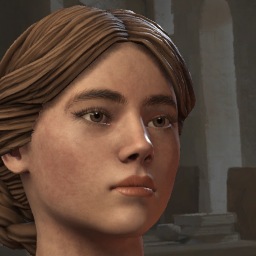

In [ ]:
#@title
image_path = EXPERIMENT_DATA_ARGS[experiment_type]["image_path"]
original_image = Image.open(image_path)
original_image = original_image.convert("RGB")
if experiment_type == "ffhq_encode" and 'shape_predictor_68_face_landmarks.dat' not in os.listdir():
    !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
    !bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2

def run_alignment(image_path):
  import dlib
  from utils.alignment import align_face
  predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
  aligned_image = align_face(filepath=image_path, predictor=predictor) 
  print("Aligned image has shape: {}".format(aligned_image.size))
  return aligned_image 

if experiment_type == "ffhq_encode":
  input_image = run_alignment(image_path)
else:
  input_image = original_image

input_image.resize(resize_dims)

Inference took 0.3833 seconds.


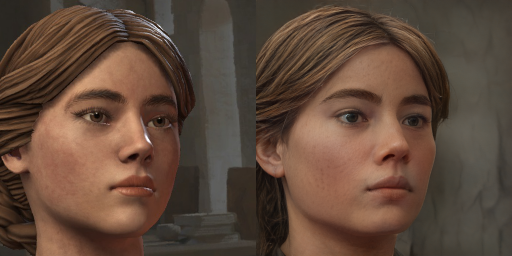

In [ ]:
#@title
img_transforms = EXPERIMENT_ARGS['transform']
transformed_image = img_transforms(input_image)

def display_alongside_source_image(result_image, source_image):
    res = np.concatenate([np.array(source_image.resize(resize_dims)),
                          np.array(result_image.resize(resize_dims))], axis=1)
    return Image.fromarray(res)

def run_on_batch(inputs, net):
    images, latents = net(inputs.to("cuda").float(), randomize_noise=False, return_latents=True)
    if experiment_type == 'cars_encode':
        images = images[:, :, 32:224, :]
    return images, latents

with torch.no_grad():
    tic = time.time()
    images, latents = run_on_batch(transformed_image.unsqueeze(0), net)
    result_image, latent = images[0], latents[0]
    toc = time.time()
    print('Inference took {:.4f} seconds.'.format(toc - tic))

# Display inversion:
display_alongside_source_image(tensor2im(result_image), input_image)

In [ ]:
torch.save(latents, 'latents.pt')

# StyleCLIP setup, run once only!

In [ ]:
% cd
% cd /content/


! pip install ftfy regex tqdm 
!pip install git+https://github.com/openai/CLIP.git 
! git clone https://github.com/bycloudai/StyleCLIP

dataset_name='ffhq'
# input dataset name 

%cd
%cd /content/StyleCLIP/global/
# input prepare data 
!python GetCode.py --dataset_name $dataset_name --code_type 'w' 
!python GetCode.py --dataset_name $dataset_name --code_type 's' 
!python GetCode.py --dataset_name $dataset_name --code_type 's_mean_std' 

os.chdir('/content/StyleCLIP/global/')

import tensorflow as tf
import numpy as np 
import torch
import clip
from PIL import Image
import pickle
import copy
import matplotlib.pyplot as plt
from MapTS import GetFs,GetBoundary,GetDt
from manipulate import Manipulator
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device) 

M=Manipulator(dataset_name='ffhq') 
fs3=np.load('./npy/ffhq/fs3.npy')
np.set_printoptions(suppress=True)

/root
/content
     |████████████████████████████████| 53 kB 1.8 MB/s 
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-1w3xoldd
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-1w3xoldd
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369328 sha256=542cbc334245de39609dae60ee965afc1f4a653275492352e59277d85c3d3d6d
  Stored in directory: /tmp/pip-ephem-wheel-cache-0sa671_7/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip
Cloning into 'StyleCLIP'...
remote: Enumerating objects: 563, done.
remote: Counting objects: 100% (102/102), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 563 (delta 34), reused 86 (delta 27), pack-reused 461
Receiving objects: 100% (563/563), 161.45 MiB | 20.27 MiB/s, done.
Resolving deltas: 100% (170/170), done.
/root
/content/StyleCLIP/global
--2022-04-20 02:35:08--  https://nvlabs-fi-cdn.nvidia.com/stylegan2/networks/stylegan2-ffhq

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 185MiB/s]


Setting up TensorFlow plugin "fused_bias_act.cu": Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Loading... Done.

Gs                              Params    OutputShape          WeightShape     
---                             ---       ---                  ---             
latents_in                      -         (?, 512)             -               
labels_in                       -         (?, 0)               -               
lod                             -         ()                   -               
dlatent_avg                     -         (512,)               -               
G_mapping/Normalize             -         (?, 512)             -               
G_mapping/Dense0                262656    (?, 512)             (512, 512)      
G_mapping/Dense1                262656    (?, 512)             (512, 512)      
G_mapping/Dense2                262656    (?, 512)             (512, 512)      
G_mapping/Dense3                262656    (?, 512)             (512, 

# StyleCLIP Body

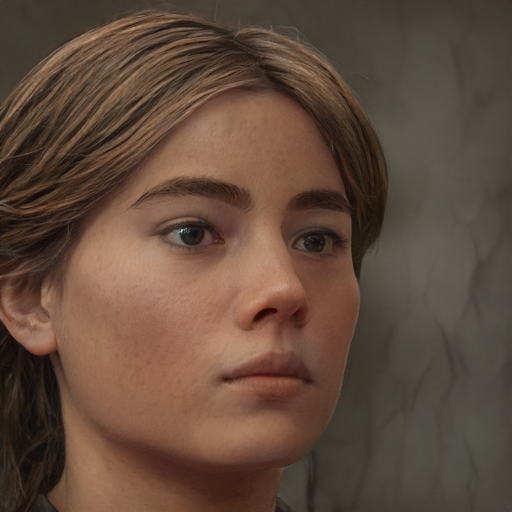

In [ ]:
latents=torch.load('/content/encoder4editing/latents.pt') # located in the top-level folder in the Colab UI
w_plus=latents.cpu().detach().numpy()
dlatents_loaded=M.W2S(w_plus)

img_index = 0
img_indexs=[img_index]

dlatent_tmp=[tmp[img_indexs] for tmp in dlatents_loaded]
M.num_images=len(img_indexs)

M.alpha=[0]
M.manipulate_layers=[0]
codes,out=M.EditOneC(0, dlatent_tmp) 
original=Image.fromarray(out[0,0]).resize((512,512))
M.manipulate_layers=None
original

# input text description 
"Neural" should describe the original image
For example

| Edit  | Neutral Text | Target Text |
| --- | --- | --- |
| Smile  | face  | smiling face |
| Gender  | female face  | male face |
| Blonde hair | face with hair | face with blonde hair |
| Hi-top fade | face with hair | face with Hi-top fade hair |
| Blue eyes | face with eyes | face with blue eyes |

In [ ]:
neutral="face with eyes" #@param {type:"string"}
target='face with brown eyes' #@param {type:"string"}
classnames=[target,neutral]
dt=GetDt(classnames,model)

0.3083


# modify manipulation strength (alhpa) and disentangle threshold (beta)

- *Manipulation strength* - positive values correspond to moving along the target direction.
- *Disentanglement threshold* - large value means more disentangled edit, just a few channels will be manipulated so only the target attribute will change (for example, grey hair). Small value means less disentangled edit, a large number of channels will be manipulated, related attributes will also change (such as wrinkle, skin color, glasses).

- In the terminal, for every manipulation, the number of channels being manipulated is printed (the number is controlled by the attribute (neutral, target) and the disentanglement threshold).

- For color transformation, usually 10-20 channels is enough. For large structure change (for example, Hi-top fade), usually 100-200 channels are required.
- For an attribute (neutral, target), if you give a low disentanglement threshold, there are just few channels (<20) being manipulated, and usually it is not enough for performing the desired edit.

num of channels being manipulated: 505


(-0.5, 1023.5, 1023.5, -0.5)

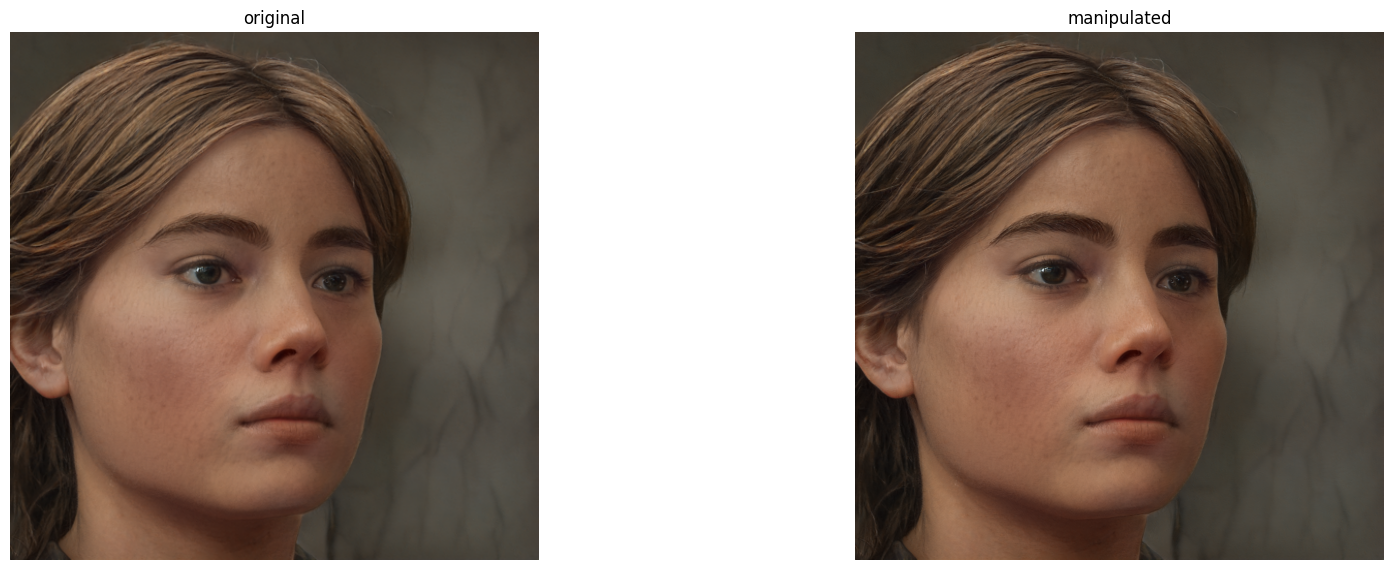

In [ ]:

#beta=0.1
#alpha=1
beta = 0.08 #@param {type:"slider", min:0.08, max:0.3, step:0.01}
alpha = 0.5 #@param {type:"slider", min:-10, max:10, step:0.1}
M.alpha=[alpha]
boundary_tmp2,c=GetBoundary(fs3,dt,M,threshold=beta)
codes=M.MSCode(dlatent_tmp,boundary_tmp2)
out=M.GenerateImg(codes)
generated=Image.fromarray(out[0,0])#.resize((512,512))


plt.figure(figsize=(20,7), dpi= 100)
plt.subplot(1,2,1)
plt.imshow(original)
plt.title('original')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(generated)
plt.title('manipulated')
plt.axis('off')